# Affine Transformation

In [1]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
figsize = (10,15)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(img)

def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Parameters

We can specify the image by adjusting its `img_path`

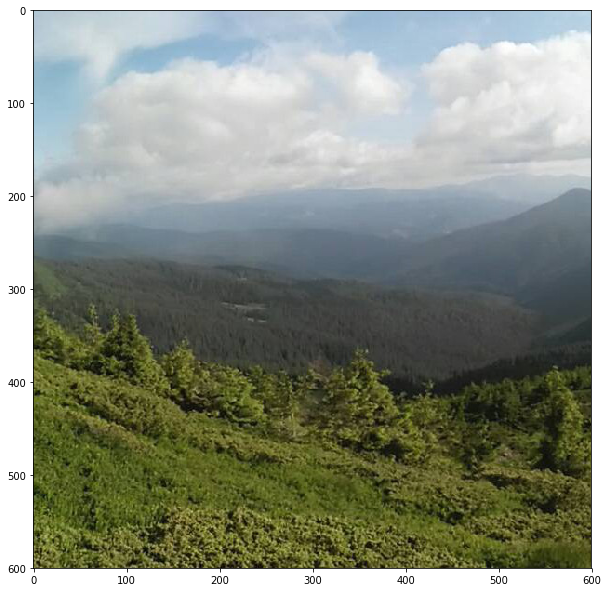

In [2]:
img_path = './res/landscape.jpg'
img = read_img(img_path)
_plot(img)

And here we will state how 3 non-colinear points were transformed in order to identify transformation matrix for the entire image

In [3]:
r,c,_ = img.shape
offset = 50
original_points = np.float32([[0,0],[r,0],[0,c]])
transformed_points = np.float32([[offset,0],[r,offset],[0,c-offset]])

## Our Implementation

We will use those auxiliary function to keep notations in algorithm consistent, i.e. when subsripting the `img[a,b]`, `a` will identify horizontal coordinates, while `b` - vertical. Currently OpenCV requires to pass point as parameter to any function in a form `(horizontal, vertical)`, while when accesses directly it should be `(vertical, horizontal)`.  
There is some overhead for changing the representation, but we accepted it in order to make our educative implementation more simple

In [4]:
def to_mtx(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype=np.int)
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
    
    return mtr

def to_img(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype=np.int)
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]
        
    return img

In Affine Transformation each point `(x,y)` is transformed to a point `$(x',y') = (a_1*x + b_1*y + c_1, a_2*x + b_2*y + c_2)$`. Or in matrix form tha will be 
$$ \begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a_1 & b_1 \\ a_2 & b_2 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} c_1 \\ c_2 \end{bmatrix},$$
or we could rewrite this as:
$$ \begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a_1 & b_1 & c_1 \\ a_2 & b_2 & c_2 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = M \cdot p$$

Where M will be our transformation matrix. And since there are 6 unknown parameters in this matrix, we need examples of at least 3 transformed points (each having x,y coordinate) to identify the matrix. And that's what we do in `getAffineTransform` function below

In [5]:
def getAffineTransform(original_points, transformed_points):
    p = []
    for x,y in original_points:
        p.append((x,y,1))

    return np.linalg.solve(p, transformed_points).T

Once we get the transformation matrix M, we would like to know how the entire transformed image would look like. That is, we want to construct an image where each pixel at location $\begin{bmatrix} x' \\ y' \end{bmatrix}$ will be equal to $M \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$, where (x,y) coordinates of original image. And that exactly what `warpAffine` function does. Besided parameters `img` for original image, `M` for transformation matrix, we also have a parameter `dsize`, which indicates the output (mapped) image size. That is, since some linear transformation `M` might map points outside of the original dimention, you might specify bigger `dsize` to capture all changes, or smaller to only focus on area of interest

In [6]:
def warpAffine(img, M, dsize):
    mtr = to_mtx(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            i_dst,j_dst = np.dot(M, [i,j,1]).astype(int)
            if i_dst >= 0 and i_dst < R:
                if j_dst >= 0 and j_dst < C:
                    dst[i_dst,j_dst] = mtr[i,j]
            
    return to_img(dst)

In [7]:
M = getAffineTransform(original_points,transformed_points)
print(M)

[[ 0.91666667 -0.08333333 50.        ]
 [ 0.08333333  0.91666667  0.        ]]


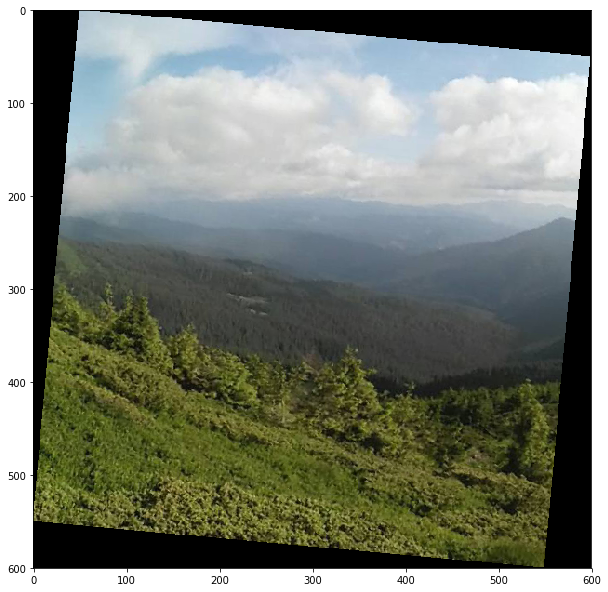

In [8]:
dst = warpAffine(img, M, img.shape[:2])
_plot(dst)

### OpenCV implementation

And in order to validate our implementation, we check results from OpenCV realization of [getAffineTransform](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getaffinetransform#getaffinetransform) and [warpAffine](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getaffinetransform#warpaffine) functions, which, as we can see, show identical results

In [9]:
M_cv2 = cv2.getAffineTransform(original_points,transformed_points)
print(M_cv2)

[[ 0.91666667 -0.08333333 50.        ]
 [ 0.08333333  0.91666667  0.        ]]


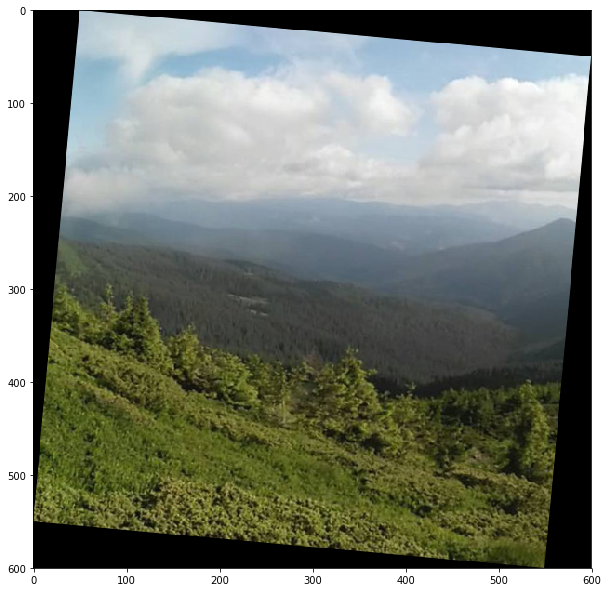

In [10]:
dst_cv2 = cv2.warpAffine(img, M_cv2, img.shape[:2])
_plot(dst_cv2)